# Differentiate pollen carrying honey bees

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/honey_bee_pollen.gif)

This notebook differentiates between images of honey bees carrying pollen and those that aren't.

These deep learning models can prove useful in bee farming for analysis/inference generation.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, transform
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import models, optimizers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten
import random

## Dataset

The dataset consists of high resolution images of individual bees on the ramp.

> ### The dataset folder

The dataset folder (link below) has the following content:



*   images folder - Contains 300x180 resolution images of bees of both categories. The image file names contain the categories - P (for pollen) or NP (for non pollen).
*   pollen_data.csv - A .csv file containing the image names and corresponding labels.



In [2]:
!wget -N https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/PollenDataset.zip
!unzip -qo PollenDataset.zip
!rm PollenDataset.zip

--2020-10-28 07:08:07--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/PollenDataset.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.60
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10524338 (10M) [application/zip]
Saving to: ‘PollenDataset.zip’

PollenDataset.zip   100%[===================>]  10.04M  --.-KB/s    in 0.1s    

2020-10-28 07:08:07 (91.6 MB/s) - ‘PollenDataset.zip’ saved [10524338/10524338]



In [3]:
# Going through the csv file

pollen = pd.read_csv('PollenDataset/pollen_data.csv')

# shuffle
pollen = pollen.sample(frac=1, random_state=113).reset_index(drop=True)

pollen

,Unnamed: 0,filename,pollen_carrying
0,544,NP23667-118r.jpg,0
1,524,NP28349-222r.jpg,0
2,650,P28616-235r.jpg,1
3,596,P12922-186r.jpg,1
4,673,NP52328-19r.jpg,0
...,...,...,...
709,253,NP55879-97r.jpg,0
710,662,P56414-106r.jpg,1
711,586,NP21559-72r.jpg,0
712,162,P268-2r.jpg,1


In [4]:
# Columns in the dataframe
print("Columns initially in the dataframe: ", list(pollen.columns))

pollen = pollen.drop(columns = pollen.columns[0])

# Columns in the dataframe now
print("Columns currently in the dataframe: ", list(pollen.columns))

Columns initially in the dataframe:  ['Unnamed: 0', 'filename', 'pollen_carrying']
Columns currently in the dataframe:  ['filename', 'pollen_carrying']


In [5]:
# Checking the spread among labels

pollen['pollen_carrying'].value_counts()

1    369
0    345
Name: pollen_carrying, dtype: int64

It is a fairly balanced dataset.

In [6]:
# Labels

pollen_classes = ["Pollen", "Non Pollen"]

## Visualization

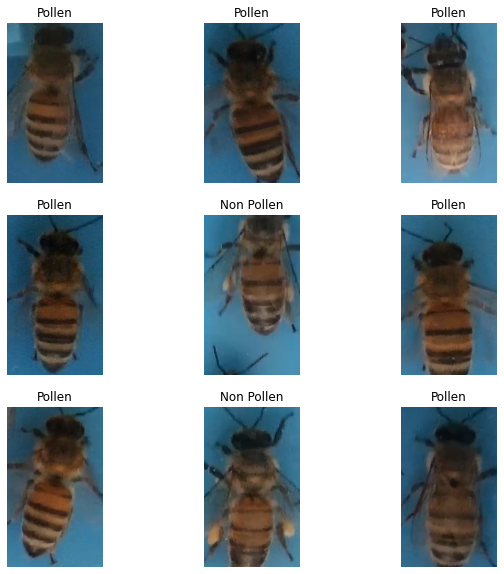

In [7]:
plt.figure(figsize=(10, 10))

for i in range(9):
    x = random.randint(0, len(pollen)-1)    # pick random sample
    ax = plt.subplot(3, 3, i + 1)
    row = pollen.loc[x] 
    image = Image.open('PollenDataset/images/' + row['filename'])
    plt.imshow(image)
    plt.title(pollen_classes[row['pollen_carrying']])
    plt.axis("off")

## Preprocessing

In [8]:
def buildX(df, rootdir = None):
    X = []    # initialising X array
    for i in range(len(pollen)):    # loop through dataset
        row = df.loc[i]
        fname, label = row['filename'], row['pollen_carrying']
        ik = rootdir + fname
        img = Image.open(ik)
        img = np.asarray(img)
        X.append(img/255)    # normalize image and append to X

    return X

In [9]:
# building X array from images
X = buildX(pollen, 'PollenDataset/images/')
y = pollen['pollen_carrying']

# as numpy array
X = np.array(X)
y = np.array(y)

# printing some inference
print("Shape of one image: ", X[0].shape)
print('The shape of X: ', X.shape)  
print('The shape of y:', y.shape)

Shape of one image:  (300, 180, 3)
The shape of X:  (714, 300, 180, 3)
The shape of y: (714,)


In [10]:
# Creating train-test using an 80-20 split
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.20, random_state = 13)

print('Number of samples in:')
print("Training set: ", xtrain.shape[0])
print("Test set: ", xtest.shape[0])

print("\nLets see the spread of labels - ")
print("Training set - \t 1: ", list(ytrain).count(1), "\t0: ", list(ytrain).count(0))
print("Test set - \t 1: ", list(ytest).count(1), "\t0: ", list(ytest).count(0))

Number of samples in:
Training set:  571
Test set:  143

Lets see the spread of labels - 
Training set - 	 1:  298 	0:  273
Test set - 	 1:  71 	0:  72


In [11]:
model = models.Sequential([
    Conv2D(64,(3,3), activation='relu', input_shape=xtrain[0].shape),
    MaxPooling2D(2,2),
    Conv2D(64,(3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128,(3,3), activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128,(3,3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(256,(3,3), activation='relu'),
    MaxPooling2D(2,2),
    
    Flatten(),
    Dropout(0.4),

    Dense(256, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
    ])

model.compile(loss='binary_crossentropy', optimizer=optimizers.Adam(0.001), metrics=['accuracy'])

In [12]:
history = model.fit(xtrain, ytrain, epochs=16, validation_data = (xtest, ytest), verbose = 1)

Epoch 1/16
18/18 [==============================] - 41s 2s/step - loss: 0.7002 - accuracy: 0.5394 - val_loss: 0.6935 - val_accuracy: 0.4965
Epoch 2/16
18/18 [==============================] - 41s 2s/step - loss: 0.6925 - accuracy: 0.5219 - val_loss: 0.6932 - val_accuracy: 0.4965
Epoch 3/16
18/18 [==============================] - 41s 2s/step - loss: 0.6906 - accuracy: 0.5219 - val_loss: 0.6839 - val_accuracy: 0.4965
Epoch 4/16
18/18 [==============================] - 41s 2s/step - loss: 0.6459 - accuracy: 0.6375 - val_loss: 0.6388 - val_accuracy: 0.6294
Epoch 5/16
18/18 [==============================] - 41s 2s/step - loss: 0.5412 - accuracy: 0.7671 - val_loss: 0.4078 - val_accuracy: 0.8182
Epoch 6/16
18/18 [==============================] - 41s 2s/step - loss: 0.3694 - accuracy: 0.8441 - val_loss: 0.3659 - val_accuracy: 0.8112
Epoch 7/16
18/18 [==============================] - 41s 2s/step - loss: 0.3050 - accuracy: 0.8581 - val_loss: 0.5652 - val_accuracy: 0.7832
Epoch 8/16
18/18 [==

In [13]:
model.evaluate(xtest, ytest)

5/5 [==============================] - 2s 424ms/step - loss: 0.2033 - accuracy: 0.9091


[0.20329207181930542, 0.9090909361839294]

## Plotting the metrics

In [14]:
def plot(history, variable, variable2):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable2])), history[variable2])
    plt.legend([variable, variable2])
    plt.title(variable)

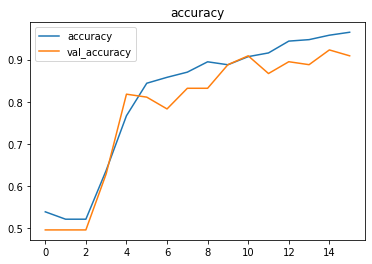

In [15]:
plot(history.history, "accuracy", "val_accuracy")

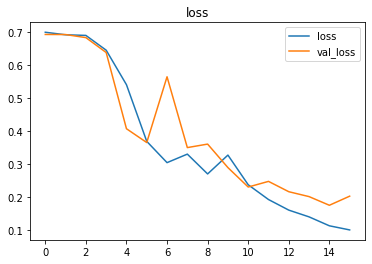

In [16]:
plot(history.history, "loss", "val_loss")

## Prediction

Actual label:  Pollen
Model prediction :  Non Pollen  ( 0.6843281  -->  1 )


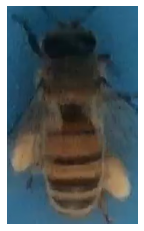

In [17]:
i = random.randint(0, len(xtest)-1)

output = model(np.expand_dims(xtest[i], 0))

pred = output.numpy()[0][0]

plt.imshow(xtrain[0])
plt.axis('off')

print("Actual label: ", pollen_classes[ytest[i]])
print("Model prediction : ", pollen_classes[int(pred>0.5)], " (", pred, " --> ", int(pred>0.5), ")")

## deepC

In [18]:
model.save('honey_bee_pollen.h5')

!deepCC honey_bee_pollen.h5

reading [keras model] from 'honey_bee_pollen.h5'
Saved 'honey_bee_pollen.onnx'
reading onnx model from file  honey_bee_pollen.onnx
Model info:
  ir_vesion :  4 
  doc       : 
WARN (ONNX): terminal (input/output) conv2d_input's shape is less than 1.
             changing it to 1.
WARN (ONNX): terminal (input/output) dense_1's shape is less than 1.
             changing it to 1.
WARN (GRAPH): found operator node with the same name (dense_1) as io node.
running DNNC graph sanity check ... passed.
Writing C++ file  honey_bee_pollen_deepC/honey_bee_pollen.cpp
INFO (ONNX): model files are ready in dir honey_bee_pollen_deepC
g++ -std=c++11 -O3 -I. -I/opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/include -isystem /opt/tljh/user/lib/python3.7/site-packages/deepC-0.13-py3.7-linux-x86_64.egg/deepC/packages/eigen-eigen-323c052e1731 honey_bee_pollen_deepC/honey_bee_pollen.cpp -o honey_bee_pollen_deepC/honey_bee_pollen.exe
Model executable  honey_bee_pollen_deepC

reading file sample.data.
Warn: conv2d_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_1_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_2_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_3_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
Warn: conv2d_4_Relu_0_pooling: auto_pad attribute is deprecated, it'll be ignored.
writing file dense_1.out.

Actual label:  Pollen
Model prediction :  Pollen  ( 0.429512  -->  0 )


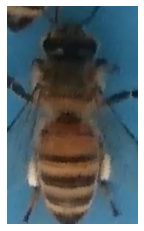

In [20]:
i = random.randint(0, len(xtest)-1)

np.savetxt('sample.data', (xtest[i]).flatten())  
    
!honey_bee_pollen_deepC/honey_bee_pollen.exe sample.data

nn_out = np.loadtxt('dense_1.out')

plt.imshow(xtrain[i])
plt.axis('off')

print()
print("Actual label: ", pollen_classes[ytest[i]])
print("Model prediction : ", pollen_classes[int(nn_out>0.5)], " (", nn_out, " --> ", int(nn_out>0.5), ")")